## Install Packages

In [102]:
import sys
!{sys.executable} -m pip install smbus2

## Import Packages

In [103]:
import cv2 as cv
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
from progressbar import ProgressBar
from picamera.array import PiRGBArray
from picamera import PiCamera
#from smbus2 import SMBus
#from mlx90614 import MLX90614
import time
import matplotlib.pyplot as plt
import numpy as np

## Label Mask Dataset

In [4]:
without_imagePaths = list(paths.list_images('without_mask'))
with_imagePaths = list(paths.list_images('with_mask'))
data = []
labels = []

without_pbar = ProgressBar()
with_pbar = ProgressBar()

for imagePath in without_pbar(without_imagePaths):
    # extract the class label from the filename
    label = 0
    
    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

for imagePath in with_pbar(with_imagePaths):
    # extract the class label from the filename
    label = 1
    
    # load the input image (224x224) and preprocess it
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
    
    # convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

100% |########################################################################|
C:\Users\12148\Anaconda3\lib\site-packages\PIL\Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100% |########################################################################|


In [5]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

## Create Mask CNN Model

In [53]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

## Train Mask Model on Dataset

In [54]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 5
BS = 47

# compile our model
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

# train the head of the network
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Epoch 1/5
128/128 [==============================] - 212s 2s/step - loss: 0.3356 - accuracy: 0.8744 - val_loss: 0.1078 - val_accuracy: 0.9755
Epoch 2/5
128/128 [==============================] - 217s 2s/step - loss: 0.1107 - accuracy: 0.9701 - val_loss: 0.0666 - val_accuracy: 0.9795
Epoch 3/5
128/128 [==============================] - 217s 2s/step - loss: 0.0706 - accuracy: 0.9793 - val_loss: 0.0545 - val_accuracy: 0.9848
Epoch 4/5
128/128 [==============================] - 184s 1s/step - loss: 0.0638 - accuracy: 0.9810 - val_loss: 0.0497 - val_accuracy: 0.9841
Epoch 5/5
128/128 [==============================] - 222s 2s/step - loss: 0.0614 - accuracy: 0.9810 - val_loss: 0.0524 - val_accuracy: 0.9815


## Test Mask Model on Dataset

In [56]:
# make predictions on the testing set
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs))

model.save("mask_detector")

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       766
           1       0.97      1.00      0.98       745

    accuracy                           0.98      1511
   macro avg       0.98      0.98      0.98      1511
weighted avg       0.98      0.98      0.98      1511

INFO:tensorflow:Assets written to: mask_detector\assets


C:\Users\12148\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\12148\Anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


## Evaluate Mask Model Performance

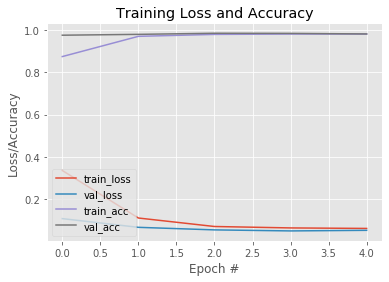

In [57]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

## Download Face Detectors

In [58]:
cascade_face_detector = cv.CascadeClassifier()
cascade_face_detector.load('haarcascade_frontalface_default.xml')

dnn_face_detector = cv.dnn.readNet('deploy.prototxt.txt', 'res10_300x300_ssd_iter_140000.caffemodel')

## Display Detected Face in Window

In [59]:
def cascadeDetectFaceAndDisplay(frame):
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    frame_gray = cv.equalizeHist(frame_gray)
    
    # Detect faces
    faces = face_detector.detectMultiScale(frame_gray, 1.3, 5)
    for (x,y,w,h) in faces:
        frame = cv.rectangle(frame, (x, y), (x + w, y+ h), (255, 0, 255), 4)
    frame = cv.resize(frame, (640,640))
    cv.imshow('Capture - Face detection', frame)

In [60]:
def dnnDetectFaceAndDisplay(frame):
    # load the input image from disk, clone it, and grab the image spatial
    # dimensions
    (h, w) = frame.shape[:2]
    # construct a blob from the image
    blob = cv.dnn.blobFromImage(frame, 1.0, (300, 300),
        (104.0, 177.0, 123.0))
    # pass the blob through the network and obtain the face detections
    dnn_face_detector.setInput(blob)
    detections = dnn_face_detector.forward()
    
    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the detection
        confidence = detections[0, 0, i, 2]
    
        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > 0.6:
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            
            frame = cv.rectangle(frame, (startX, startY), (endX, endY), (255, 0, 255), 2)

            
    frame = cv.resize(frame, (600,600))
    cv.imshow('Capture - Face detection', frame)

## Display Detected Face and Mask Prediction in Window

In [124]:
def dnnDetectMaskAndDisplay(frame):
    # load the input image from disk, clone it, and grab the image spatial
    # dimensions
    (h, w) = frame.shape[:2]
    # construct a blob from the image
    blob = cv.dnn.blobFromImage(frame, 1.0, (100, 100),
        (104.0, 177.0, 123.0))
    # pass the blob through the network and obtain the face detections
    dnn_face_detector.setInput(blob)
    detections = dnn_face_detector.forward()
    
    faces = []
    locs = []
    preds = []
    
    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the detection
        confidence = detections[0, 0, i, 2]
    
        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > 0.3:
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            
            # ensure the bounding boxes fall within the dimensions of
            # the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            
            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = frame[startY:endY, startX:endX]
            face = cv.cvtColor(face, cv.COLOR_BGR2RGB)
            face = cv.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
            face = np.expand_dims(face, axis=0)
            
            (withoutMask, mask) = model.predict(face)[0]
            
            # determine the class label and color we'll use to draw
            # the bounding box and text
            label = "Mask" if mask > withoutMask else "No Mask"
            color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
            
            # display the label and bounding box rectangle on the output
            # frame
            cv.putText(frame, label, (startX, startY - 30),
                cv.FONT_HERSHEY_SIMPLEX, 1, color, 2)
            cv.rectangle(frame, (startX, startY), (endX, endY), color, 2)

            
    frame = cv.resize(frame, (640, 480))
    cv.putText(frame, '98.6F', (550, 25),
                cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv.imshow('Capture - Face detection', frame)

## Detect Face and Make Mask Prediction for Display

In [127]:
def dnnDetectMask(frame):
    # load the input image from disk, clone it, and grab the image spatial
    # dimensions
    (h, w) = frame.shape[:2]
    # construct a blob from the image
    blob = cv.dnn.blobFromImage(frame, 1.0, (100, 100),
        (104.0, 177.0, 123.0))
    # pass the blob through the network and obtain the face detections
    dnn_face_detector.setInput(blob)
    detections = dnn_face_detector.forward()
    
    label = ''
    
    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the detection
        confidence = detections[0, 0, i, 2]
    
        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > 0.3:
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            
            # ensure the bounding boxes fall within the dimensions of
            # the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            
            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = frame[startY:endY, startX:endX]
            face = cv.cvtColor(face, cv.COLOR_BGR2RGB)
            face = cv.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
            face = np.expand_dims(face, axis=0)
            
            (withoutMask, mask) = model.predict(face)[0]
            
            # determine the class label and color we'll use to draw
            # the bounding box and text
            label = "Mask" if mask > withoutMask else "No Mask"
            color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
            
            # display the label and bounding box rectangle on the output
            # frame
            cv.putText(frame, label, (startX, startY - 30),
                cv.FONT_HERSHEY_SIMPLEX, 1, color, 2)
            cv.rectangle(frame, (startX, startY), (endX, endY), color, 2)
            
            # add the face and bounding boxes to their respective
            # lists

            
    return (cv.resize(frame, (640, 480)), label)

## Read Body Temperature

In [ ]:
def readTemp(sensor, temp, validTemp)
    measured = sensor.get_object_1()
    if (measured >= 36):
        if (validTemp == 0 || measured > temp):
            temp = measured
        validTemp = 1
    else:
        validTemp = 0
            
    return temp, validTemp

## Real Time Mask Detection on Laptop

In [158]:
cap = cv.VideoCapture(0)
cap.set(cv.CAP_PROP_BUFFERSIZE, 2)


while cap.isOpened():
    ret, frame = cap.read()
    
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    frame, label = dnnDetectMask(frame)
    cv.putText(frame, '98.6F', (532, 25),
                cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    if (label == 'No Mask'):
        cv.rectangle(frame, (140, 43), (527, 95), (0, 0, 255), -1)
        cv.putText(frame, 'ENTRY DENIED', (145, 87),
                cv.FONT_HERSHEY_SIMPLEX, 1.7, (0, 0, 0), 3)
    elif (label == 'Mask'):
        cv.rectangle(frame, (123, 43), (545, 95), (0, 255, 0), -1)
        cv.putText(frame, 'ENTRY GRANTED', (120, 87),
                cv.FONT_HERSHEY_SIMPLEX, 1.7, (0, 0, 0), 3)
        
    cv.imshow('Capture - Face detection', frame)    
        
    if cv.waitKey(1) == ord('q'):
        break
        
        
cap.release()
cv.destroyAllWindows()

## Real Time Mask Detection on Raspberry PI

In [ ]:
camera = PiCamera()
camera.resolution = (640, 480)
camera.framerate = 32
rawCapture = PiRGBArray(camera, size=(640, 480))

time.sleep(0.1)

# capture frames from the camera
for frame in camera.capture_continuous(rawCapture, format="bgr", use_video_port=True):
    # grab the raw NumPy array representing the image, then initialize the timestamp
    # and occupied/unoccupied text
    frame = frame.array
    
    # show the frame
    dnnDetectMaskAndDisplay(frame)
    key = cv.waitKey(1) & 0xFF
    
    # clear the stream in preparation for the next frame
    rawCapture.truncate(0)
    
    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break
        
cv.destroyAllWindows()

## Real Time Entry Requirement Detection on Raspberry Pi

In [104]:
camera = PiCamera()
camera.resolution = (640, 480)
camera.framerate = 32
rawCapture = PiRGBArray(camera, size=(640, 480))

time.sleep(0.1)

bus = SMBus(1)
sensor = MLX90614(bus, address=0x5A)
temp = 0
validTemp = 0

# capture frames from the camera
for frame in camera.capture_continuous(rawCapture, format="bgr", use_video_port=True):
    # grab the raw NumPy array representing the image, then initialize the timestamp
    # and occupied/unoccupied text
    frame = frame.array
    
    # show the frame
    frame, label = dnnDetectMask(frame)
    temp, validTemp = readTemp(sensor, temp, validTemp)
    
    if (label == 'No Mask'):
        cv.rectangle(frame, (140, 43), (527, 95), (0, 0, 255), -1)
        cv.putText(frame, 'ENTRY DENIED', (145, 87),
                cv.FONT_HERSHEY_SIMPLEX, 1.7, (0, 0, 0), 3)
    elif (label == 'Mask'):
        if (temp <= 38):
            cv.rectangle(frame, (startX, startY), (endX, endY), (0, 255, 0), 2)
            cv.putText(frame, 'ENTRY GRANTED', (startX, startY - 30),
                cv.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
        else:
            cv.rectangle(frame, (startX, startY), (endX, endY), (0, 0, 255), 2)
            cv.putText(frame, 'ENTRY DENIED', (startX, startY - 30),
                cv.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
    
    if (temp <= 38):
        color = (0, 255, 0)
    else:
        color = (255, 0, 0)
    
    farenheit = (temp * 9 / 5) + 32
    temp_str = str(farenheit) + 'F'
        
    cv.putText(frame, temp_str, (550, 25),
                cv.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    
    cv.imshow('Capture - Face detection', frame)
    key = cv.waitKey(1) & 0xFF
    
    # clear the stream in preparation for the next frame
    rawCapture.truncate(0)
    
    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break
        
cv.destroyAllWindows()

NameError: name 'PiCamera' is not defined